In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
import time
from datetime import datetime
from datetime import timedelta
sns.set()

This code imports necessary libraries and modules for implementing a machine learning model using TensorFlow, data manipulation using NumPy and pandas, data visualization using matplotlib and seaborn, and data preprocessing using scikit-learn. It also imports a custom 'model' module and some time-related functions.

In [2]:
df = pd.read_csv('GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


This code reads a CSV file named 'GOOG-year.csv' into a pandas DataFrame, converts the first column into a list of datetime objects, and then displays the first five rows of the DataFrame.

In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 3].values.reshape((-1,1))).reshape((-1))

This code normalizes the values in the 4th column of a DataFrame (df) using the MinMaxScaler, and stores the normalized values in the variable close_normalize.

In [4]:
close_normalize.shape

(252,)

This code returns the shape (dimensions) of a variable called `close_normalize`.

In [5]:
class Encoder:
    def __init__(self, input_, dimension=2, learning_rate=0.01, hidden_layer=256, epoch=20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_size])
    
        layer_dims = [input_size, hidden_layer, dimension, hidden_layer, input_size]
        weights = {f'{l}_h{i}': tf.Variable(tf.random_normal([layer_dims[i], layer_dims[i + 1]])) for l in ['encoder', 'decoder'] for i in range(len(layer_dims) - 1)}
        biases = {f'{l}_b{i}': tf.Variable(tf.random_normal([layer_dims[i + 1]])) for l in ['encoder', 'decoder'] for i in range(len(layer_dims) - 1)}
    
        def layer(input_, weight_key, bias_key, activation=tf.nn.sigmoid):
            return activation(tf.add(tf.matmul(input_, weights[weight_key]), biases[bias_key]))
    
        self.second_layer_encoder = layer(layer(layer(self.X, 'encoder_h1', 'encoder_b1'), 'encoder_h2', 'encoder_b2'), 'decoder_h1', 'decoder_b1')
        second_layer_decoder = layer(layer(layer(self.second_layer_encoder, 'decoder_h1', 'decoder_b1'), 'decoder_h2', 'decoder_b2'), 'encoder_h1', 'encoder_b1')
    
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})


This code introduces the `Encoder` class which implements an autoencoder neural network—a subset of artificial neural networks designed to create efficient data representations. Autoencoders are comprised of two primary components: an encoder, which compresses input data into a compact form, and a decoder, which attempts to reconstruct the original data from this compressed representation.

Here's an overview of the code's functionalities:

1. Initialization (`__init__` method): This section initializes the encoder's properties, such as input size, learning rate, hidden layer size, and the number of training epochs. A TensorFlow placeholder named `self.X` is created to store input data. The dimensions of encoder and decoder layers are defined, and weights and biases dictionaries are set up for these layers.

2. Layer Definition (`layer` function): Here, a utility function `layer` is defined. It performs a basic operation of computing a weighted sum followed by an activation function (by default, sigmoid). The function takes an input tensor, weight key, bias key, and an optional activation function.

3. Encoder Layers: This part constructs the encoder layers by sequentially chaining the layers using the `layer` function. The encoder compresses input data through multiple hidden layers, and the result of the final encoder layer is stored in `self.second_layer_encoder`.

4. Decoder Layers: Similarly, the decoder is constructed by chaining layers in reverse order using the `layer` function. The decoder aims to recreate the original data from the compressed representation, and the result of the final decoder layer is stored as `second_layer_decoder`.

5. Loss and Optimization: The code defines the reconstruction loss as the mean squared difference between the input data and the output of the decoder. An optimizer (RMSProp) is established to minimize this reconstruction loss during training.

6. TensorFlow Session: A TensorFlow session (`self.sess`) is created to execute operations within the TensorFlow graph. Global variables are initialized within the session.

7. Training Loop: The script iterates through the specified number of training epochs. In each epoch, the autoencoder is trained by executing the optimizer on the input data and calculating the loss.

8. Encoding (`encode` method): The `encode` method allows input data to be compressed into a compact representation by utilizing the second layer of the encoder.

In summary, this code defines an autoencoder architecture and its training process. Autoencoders are valuable for reducing data dimensionality and learning essential features. They find applications in various tasks like data compression, denoising, and feature extraction.

In [6]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

epoch: 10 loss: 0.150638 time: 0.0008144378662109375
epoch: 20 loss: 0.0652009 time: 0.0007433891296386719
epoch: 30 loss: 0.0556741 time: 0.0007736682891845703
epoch: 40 loss: 0.0430575 time: 0.0007085800170898438
epoch: 50 loss: 0.0287333 time: 0.0006804466247558594
epoch: 60 loss: 0.0152949 time: 0.0007014274597167969
epoch: 70 loss: 0.0436488 time: 0.0006766319274902344
epoch: 80 loss: 0.0830372 time: 0.0007102489471435547
epoch: 90 loss: 0.0531746 time: 0.0007026195526123047
epoch: 100 loss: 0.0455618 time: 0.0006778240203857422


(252, 32)

This code resets the TensorFlow default graph, creates an Encoder object with the given parameters, encodes the input data (close_normalize) into a thought vector, and then outputs the shape of the thought vector.

In [7]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

This code initializes five different ensemble regression models from the scikit-learn library, with specified parameters: AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, and RandomForestRegressor.

In [8]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

This code trains five different machine learning models (AdaBoost, Bagging, Extra Trees, Gradient Boosting, and Random Forest) using the given input data (thought_vector) and target output (close_normalize).

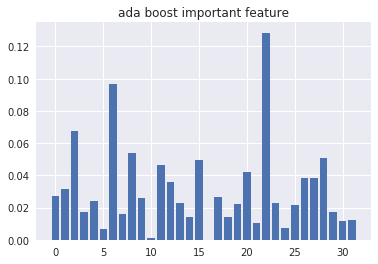

In [9]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

This code creates a bar plot of the 32 most important features according to the AdaBoost model, displays the title "ada boost important feature" on the plot, and then shows the plot.

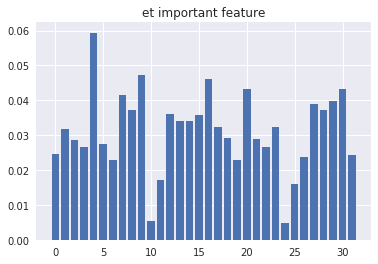

In [10]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

This code will create a bar plot showing the importance of each of the 32 features for an Extra Trees (et) model and display the plot with the title 'et important feature'.

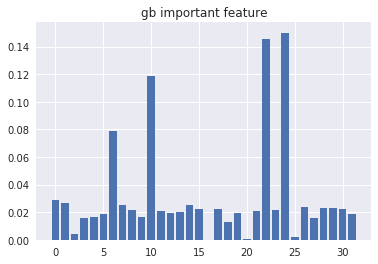

In [11]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

This code creates a bar plot of the 32 most important features according to Gradient Boosting (gb) model and displays it with a title 'gb important feature'.

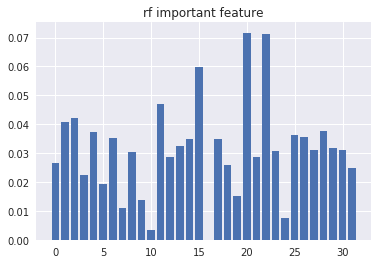

In [12]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

This code creates a bar chart showing the importance of 32 features in a random forest model (rf) and displays the chart with the title 'rf important feature'.

In [13]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

This code makes predictions using five different machine learning models (ada, bagging, et, gb, and rf) on the given 'thought_vector' and stores the predictions in respective variables.

In [14]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

This code creates a set of actual predictions for different models (AdaBoost, Bagging, ExtraTrees, Gradient Boosting, and Random Forest) by concatenating the first value of close_normalize with the respective model predictions (excluding the last element). Then, it stacks these actual predictions along with close_normalize vertically and transposes the result. Finally, it creates a DataFrame with the stacked predictions.

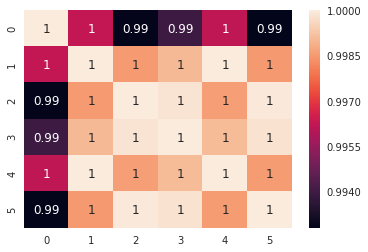

In [15]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

This code creates and displays a heatmap of the correlation matrix for the data in "corr_df" with annotations for each cell.

Wow, I do not expect this heatmap. Totally a heat!

In [16]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

This code trains an XGBoost regressor model with specified parameters on given data and stops the training early if the evaluation metric doesn't improve for 20 rounds.

In [17]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

This code predicts values using a trained classifier, stacks the predictions with the first value of `close_normalize`, and formats the dates in `date_ori` as a list of strings in 'YYYY-MM-DD' format.

In [18]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

This code reverses the transformation applied to an array using the inverse_transform function of the minmax object and returns the resulting array.

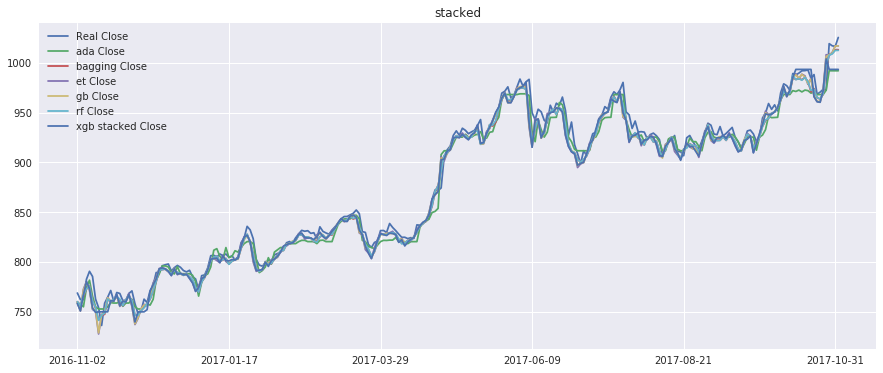

In [25]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

This code creates a plot showing the real closing price and the predicted closing prices of different models, such as AdaBoost, Bagging, Extra Trees, Gradient Boosting, Random Forest, and XGBoost stacked, over a specific date range. The plot is displayed with labeled legends, custom tick intervals, and a title.

In [20]:
def predict(count, history=5):
    for _ in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1, 1)))
        
        models = [ada, bagging, et, gb, rf]
        preds = [model.predict(thought_vector)[-1] for model in models]
        [lst.append(pred) for lst, pred in zip([ada_list, bagging_list, et_list, gb_list, rf_list], preds)]
        
        stacked_actual = [np.hstack([xgb_list[-history], pred[:-1]]) for pred in preds]
        stack_predict = np.vstack(stacked_actual + [xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1] + timedelta(days=1))


This code predicts future values for a given count using an ensemble of machine learning models and updates the prediction lists and dates accordingly.

In [21]:
predict(30, history = 5)

This code calls a function named "predict" with input parameters 30 and history = 5, likely making a prediction based on a value of 30 and using a history of 5 previous data points.

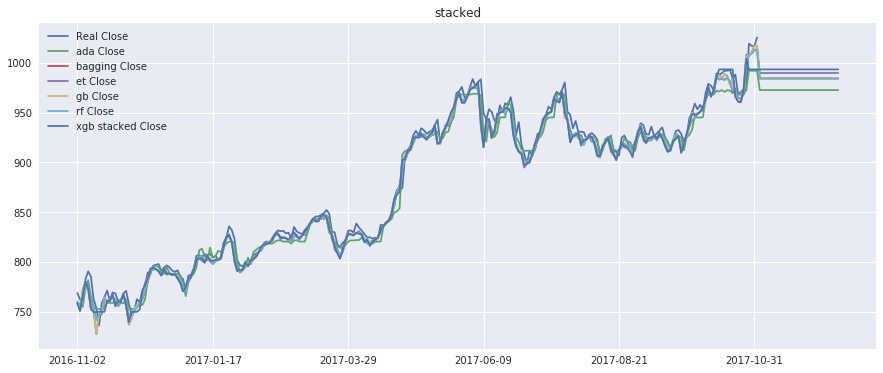

In [29]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

This code creates a plot showing the real closing prices of a stock and the predicted closing prices using various machine learning models (ada, bagging, et, gb, rf, and xgb stacked). It then displays the plot with a legend, custom x-axis ticks, and a title.